<a href="https://colab.research.google.com/github/gauravreddy08/learning-pytorch/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02 | **PyTorch** Image Classfication
https://www.learnpytorch.io/02_pytorch_classification/


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


## Getting the **data** ready

In [3]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, 
                    noise=0.03,
                    random_state=42)

In [4]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]), array([1, 1, 1, 1, 0]))

In [5]:
circles = pd.DataFrame({'x1': X[:, 0], "x2": X[:, 1], 'label': y})
circles.head(10)

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


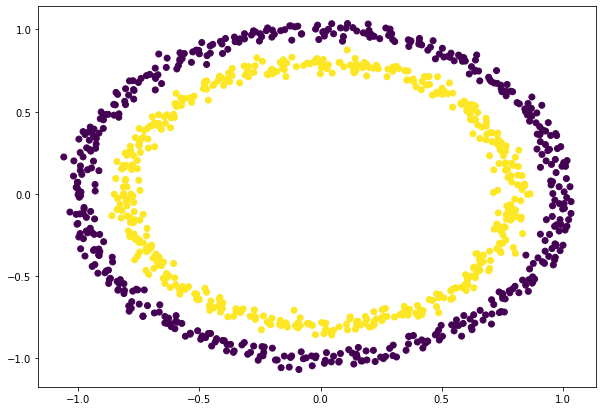

In [6]:
plt.figure(figsize=(10, 7))
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y);

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [9]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [10]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  
  def forward(self, x: torch.nn.Parameter) -> torch.nn.Parameter:
    return self.layer_2(self.layer_1(x))

torch.manual_seed(42)

model_0 = CircleModelV0().to(device)
model_0, model_0.state_dict()

(CircleModelV0(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ), OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188]], device='cuda:0')),
              ('layer_1.bias',
               tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
              ('layer_2.weight',
               tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
              ('layer_2.bias', tensor([-0.2060], device='cuda:0'))]))

https://playground.tensorflow.org/

another way...

In [11]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
loss_fn = nn.BCEWithLogitsLoss() # for "numeric stability" they said
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [13]:
def accuracy_fn(y_true, y_pred):
   correct = torch.eq(y_true, y_pred).sum().item()
   acc = (correct/len(y_pred)) * 100
   return acc

## **Training** model


In [14]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test[:5])

y_logits, y_test[:5]

(tensor([[-0.0338],
         [-0.0309],
         [ 0.0894],
         [-0.0692],
         [ 0.2967]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

In [15]:
y_pred_prods = torch.sigmoid(y_logits)
y_pred_prods

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

In [16]:
y_preds = torch.round(y_pred_prods.squeeze(dim=1))
y_preds

tensor([0., 0., 1., 0., 1.], device='cuda:0')

In [17]:
(torch.eq(y_preds, y_test[:5]).sum().item() / 5) * 100

80.0

In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 100

for epoch in range(EPOCHS):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()

  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                    y_pred=test_pred)
    
  if epoch%10==0:
    print(f"Epoch: {epoch} | A: {acc}% L: {loss} | testA: {test_acc}% testL: {test_loss}")

Epoch: 0 | A: 51.87500000000001% L: 0.6979604959487915 | testA: 57.99999999999999% testL: 0.6943961381912231
Epoch: 10 | A: 51.24999999999999% L: 0.6958983540534973 | testA: 53.0% testL: 0.6930527091026306
Epoch: 20 | A: 51.625% L: 0.6949014663696289 | testA: 49.5% testL: 0.692543625831604
Epoch: 30 | A: 51.125% L: 0.6943498253822327 | testA: 49.5% testL: 0.6923599243164062
Epoch: 40 | A: 50.875% L: 0.6940092444419861 | testA: 51.0% testL: 0.6923156380653381
Epoch: 50 | A: 50.24999999999999% L: 0.6937821507453918 | testA: 50.0% testL: 0.6923370361328125
Epoch: 60 | A: 50.0% L: 0.6936231851577759 | testA: 51.5% testL: 0.6923913359642029
Epoch: 70 | A: 50.24999999999999% L: 0.6935079097747803 | testA: 51.0% testL: 0.6924624443054199
Epoch: 80 | A: 49.875% L: 0.6934223175048828 | testA: 50.0% testL: 0.6925414800643921
Epoch: 90 | A: 49.875% L: 0.6933573484420776 | testA: 53.0% testL: 0.692623496055603


In [19]:
# make predictions

!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
from helper_functions import plot_predictions, plot_decision_boundary

--2023-02-03 17:13:12--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10160 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.92K  --.-KB/s    in 0s      

2023-02-03 17:13:12 (71.2 MB/s) - ‘helper_functions.py’ saved [10160/10160]



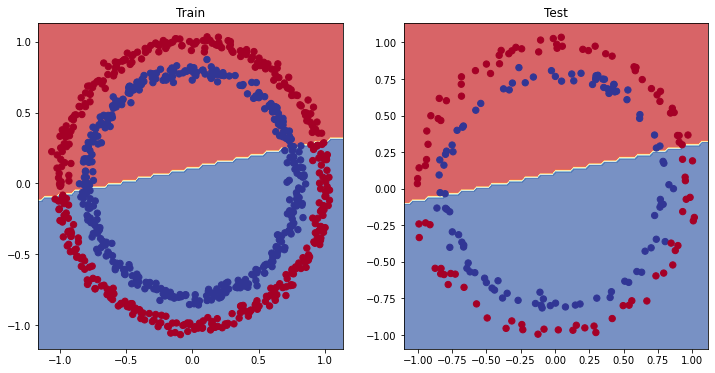

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### **Improving** the model

In [21]:
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)
model_1

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [22]:
EPOCHS = 100

for epoch in range(EPOCHS):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                    y_pred=test_pred)
    
  if epoch%10==0:
    print(f"Epoch: {epoch} | A: {acc}% L: {loss} | testA: {test_acc}% testL: {test_loss}")

Epoch: 0 | A: 50.875% L: 0.6939550638198853 | testA: 51.0% testL: 0.6926146745681763
Epoch: 10 | A: 50.24999999999999% L: 0.6936882138252258 | testA: 50.0% testL: 0.6927036643028259
Epoch: 20 | A: 50.125% L: 0.6935123801231384 | testA: 49.5% testL: 0.6928302049636841
Epoch: 30 | A: 50.5% L: 0.6933860778808594 | testA: 48.0% testL: 0.6929664611816406
Epoch: 40 | A: 50.375% L: 0.6932917833328247 | testA: 49.0% testL: 0.693103015422821
Epoch: 50 | A: 49.875% L: 0.6932203769683838 | testA: 50.0% testL: 0.6932356357574463
Epoch: 60 | A: 49.375% L: 0.6931657791137695 | testA: 51.5% testL: 0.6933622360229492
Epoch: 70 | A: 49.375% L: 0.693123996257782 | testA: 50.5% testL: 0.6934814453125
Epoch: 80 | A: 50.125% L: 0.693091869354248 | testA: 50.0% testL: 0.6935926675796509
Epoch: 90 | A: 50.5% L: 0.6930670142173767 | testA: 48.5% testL: 0.693695604801178


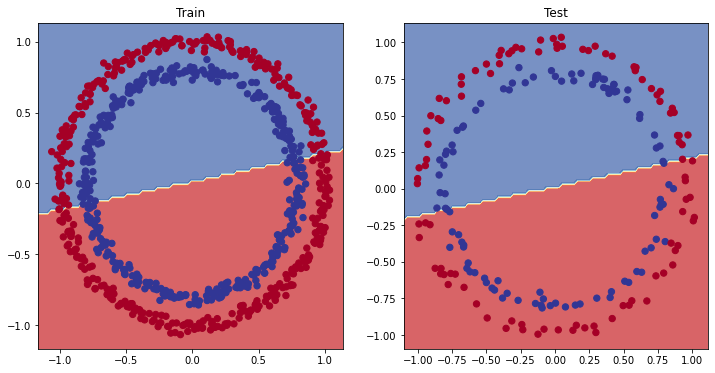

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

#### Let's welcome ***non-linearity***

In [24]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  
  def forward(self, x: torch.nn.Parameter) -> torch.nn.Parameter:
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

torch.manual_seed(42)

model_2 = CircleModelV2().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [25]:
EPOCHS = 1000

for epoch in range(EPOCHS):
  model_2.train()

  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()

  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                    y_pred=test_pred)
    
  if epoch%100==0:
    print(f"Epoch: {epoch} | A: {acc}% L: {loss} | testA: {test_acc}% testL: {test_loss}")

Epoch: 0 | A: 50.0% L: 0.6929463148117065 | testA: 50.0% testL: 0.6931881308555603
Epoch: 100 | A: 52.87500000000001% L: 0.691152811050415 | testA: 52.5% testL: 0.6910240054130554
Epoch: 200 | A: 53.37499999999999% L: 0.6897743940353394 | testA: 55.00000000000001% testL: 0.6893960237503052
Epoch: 300 | A: 53.0% L: 0.6879494190216064 | testA: 56.00000000000001% testL: 0.6872316002845764
Epoch: 400 | A: 52.75% L: 0.6851678490638733 | testA: 56.49999999999999% testL: 0.6841148138046265
Epoch: 500 | A: 52.75% L: 0.6810224652290344 | testA: 56.49999999999999% testL: 0.6794120073318481
Epoch: 600 | A: 54.50000000000001% L: 0.675148606300354 | testA: 56.00000000000001% testL: 0.6728507876396179
Epoch: 700 | A: 58.375% L: 0.6665886044502258 | testA: 59.0% testL: 0.6632164716720581
Epoch: 800 | A: 64.0% L: 0.6515954732894897 | testA: 67.5% testL: 0.647568941116333
Epoch: 900 | A: 74.0% L: 0.6236233115196228 | testA: 79.0% testL: 0.6214525699615479


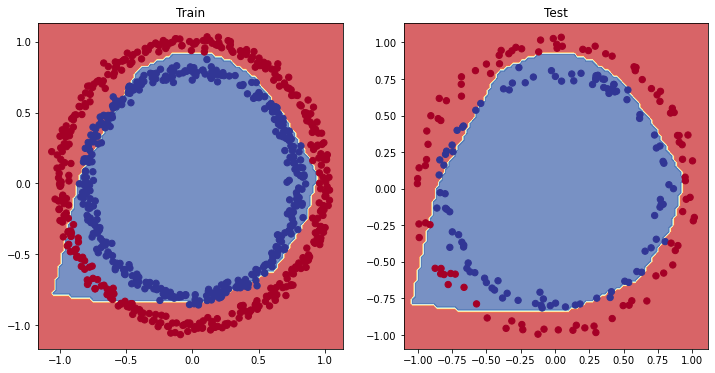

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

In [41]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000,
                  n_features=2,
                  centers=4,
                  cluster_std=2,
                  random_state=42)

X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

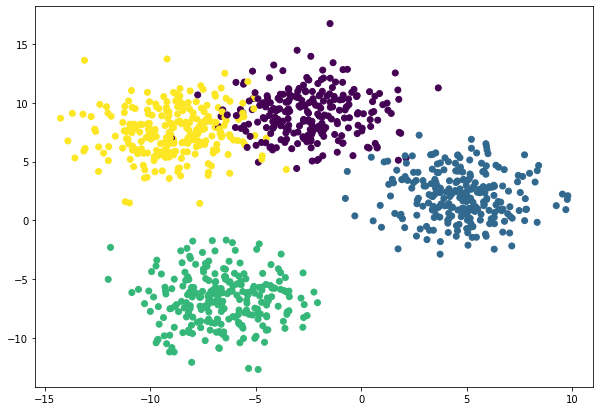

In [42]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y)

In [43]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [65]:
class MultiClassification(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()

    self.linear_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_stack(x)

torch.cuda.manual_seed(42)
torch.manual_seed(42)
model_3 = MultiClassification(input_features=2, 
                              output_features=4).to(device)
model_3                            

MultiClassification(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [66]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.3)

In [67]:
EPOCHS = 1000

for epoch in range(EPOCHS):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()

  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                    y_pred=test_pred)
    
  if epoch%100==0:
    print(f"Epoch: {epoch} | A: {acc}% L: {loss} | testA: {test_acc}% testL: {test_loss}")

Epoch: 0 | A: 40.5% L: 1.1674058437347412 | testA: 56.00000000000001% testL: 0.9644026160240173
Epoch: 100 | A: 96.0% L: 0.09037766605615616 | testA: 97.0% testL: 0.07910162210464478
Epoch: 200 | A: 96.375% L: 0.08586087822914124 | testA: 97.0% testL: 0.07014777511358261
Epoch: 300 | A: 95.875% L: 0.11387725919485092 | testA: 97.5% testL: 0.0786019116640091
Epoch: 400 | A: 96.25% L: 0.10187599807977676 | testA: 97.5% testL: 0.07053086161613464
Epoch: 500 | A: 96.5% L: 0.0787067636847496 | testA: 97.5% testL: 0.061617594212293625
Epoch: 600 | A: 96.5% L: 0.07714442908763885 | testA: 97.5% testL: 0.06164061650633812
Epoch: 700 | A: 96.375% L: 0.07577137649059296 | testA: 97.5% testL: 0.06061709299683571
Epoch: 800 | A: 96.625% L: 0.07499966025352478 | testA: 97.5% testL: 0.059049032628536224
Epoch: 900 | A: 96.625% L: 0.07388768345117569 | testA: 97.5% testL: 0.05852668732404709


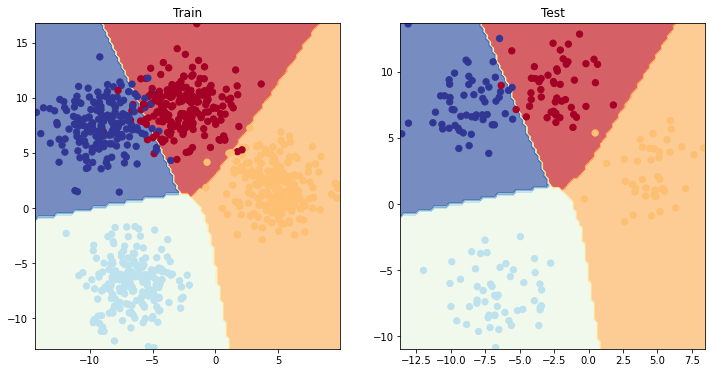

In [68]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [ ]:
!pip install torchmetrics

In [70]:
X_test.device

device(type='cuda', index=0)

In [75]:
model_3 = model_3.to(device)

In [76]:
from torchmetrics import Accuracy

with torch.inference_mode():
  test_logits = model_3(X_test).squeeze()
  test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)
torchmetrics_accuracy(test_pred, y_test)

tensor(0.9750, device='cuda:0')